# Pulse sequence evaluation

Using arbitrary units. Energy is normalized to the standard deviation in chemical shift strengths. Reduced Planck's constant $\hbar \equiv 1$.

In [39]:
import qutip as qt
import numpy as np
import matplotlib.pyplot as plt
import sys, os
import pandas as pd
import multiprocessing as mp

In [2]:
sys.path.append('..')

In [3]:
import pulse_sequences as ps

## Define system

In [16]:
dipolar_strength = 1e1
pulse_width = 1e-4  # time is relative to chemical shift strength
delay = 1e-3
rot_error = 1e-2
N = 4  # number of spins
ensemble_size = 50

In [5]:
X, Y, Z = ps.get_collective_spin(N)

In [17]:
Hsys_ensemble = [ps.get_Hsys(N, dipolar_strength=dipolar_strength) for _ in range(ensemble_size)]
pulses_ensemble = [
    ps.get_pulses(H, X, Y, Z, pulse_width, delay, rot_error=rot_error) for H in Hsys_ensemble
]

In [18]:
Utarget = qt.identity(Hsys_ensemble[0].dims[0])

## Define and evaluate pulse sequences



In [19]:
ps.get_mean_fidelity(ps.yxx24, Utarget, pulses_ensemble)

0.999997381165852

In [20]:
ps.get_mean_fidelity(ps.yxx48, Utarget, pulses_ensemble)

0.9999921605298719

In [24]:
ps.get_mean_fidelity(ps.mcts12_2, Utarget, pulses_ensemble)

0.9940775812866163

In [25]:
ps.get_mean_fidelity(ps.mcts12_3, Utarget, pulses_ensemble)

0.9980730473527457

In [26]:
ps.get_mean_fidelity(ps.mcts12_4, Utarget, pulses_ensemble)

0.9980293112215896

In [27]:
ps.get_mean_fidelity(ps.az3, Utarget, pulses_ensemble)

0.9958282061761383

## Evaluate robustness

Looking at several different sources of errors:

- Non-negligible higher-order terms in Magnus expansion
- Rotation errors
- Phase transients
- Offset errors

In [91]:
pulses_ensemble = [
    ps.get_pulses(H, X, Y, Z, pulse_width, delay, rot_error=0)
    for H in Hsys_ensemble
]

In [97]:
yxx48_fidelities = np.array([
    ps.get_fidelity(ps.yxx48, Utarget, p)
    for p in pulses_ensemble
])

In [98]:
1-np.mean(yxx48_fidelities), np.std(yxx48_fidelities)

(1.0160178076867865e-05, 2.1976104601577872e-05)

In [102]:
yxx24_fidelities = np.array([
    ps.get_fidelity(ps.yxx24, Utarget, p)
    for p in pulses_ensemble
])

In [103]:
1-np.mean(yxx24_fidelities), np.std(yxx24_fidelities)

(2.598338609938189e-06, 5.592592951128164e-06)

In [105]:
az3_fidelities = np.array([
    ps.get_fidelity(ps.az3, Utarget, p)
    for p in pulses_ensemble
])

In [106]:
1-np.mean(az3_fidelities), np.std(az3_fidelities)

(0.0029093752036906118, 0.004033137682925701)

### Rotation errors

In [55]:
rot_errors = np.linspace(-.2, .2, 25)

In [86]:
def f(rot_error):
    pe = [ps.get_pulses(H, X, Y, Z, pulse_width, delay, rot_error=rot_error) for H in Hsys_ensemble]
    fidelities = [ps.get_fidelity(ps.yxx48, Utarget, p) for p in pe]
    return np.mean(fidelities), np.std(fidelities)

In [87]:
with mp.Pool(4) as p:
    fidelities = p.map(f, rot_errors)

In [88]:
fidelities, f_std = zip(*fidelities)

In [89]:
fidelities = np.array(fidelities)
f_std = np.array(f_std)

In [73]:
def g(rot_error):
    pe = [ps.get_pulses(H, X, Y, Z, pulse_width, delay, rot_error=rot_error) for H in Hsys_ensemble]
    fidelities = [ps.get_fidelity(ps.yxx24, Utarget, p) for p in pe]
    return np.mean(fidelities), np.std(fidelities)

In [114]:
with mp.Pool(4) as p:
    fidelities2 = p.map(g, rot_errors)

In [115]:
fidelities2, f_std2 = zip(*fidelities2)

In [116]:
fidelities2 = np.array(fidelities2)
f_std2 = np.array(f_std2)

In [108]:
def h(rot_error):
    pe = [ps.get_pulses(H, X, Y, Z, pulse_width, delay, rot_error=rot_error) for H in Hsys_ensemble]
    fidelities = [ps.get_fidelity(ps.az3, Utarget, p) for p in pe]
    return np.mean(fidelities), np.std(fidelities)

In [109]:
with mp.Pool(4) as p:
    fidelities3 = p.map(h, rot_errors)

In [112]:
fidelities3, f_std3 = zip(*fidelities3)

In [113]:
fidelities3 = np.array(fidelities3)
f_std3 = np.array(f_std3)

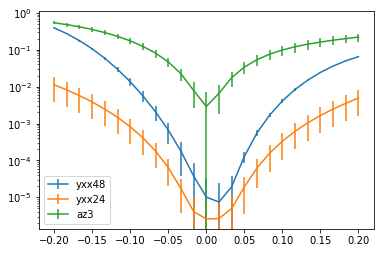

In [117]:
plt.errorbar(rot_errors, 1-fidelities, yerr=f_std, label='yxx48')
plt.errorbar(rot_errors, 1-fidelities2, yerr=f_std2, label='yxx24')
plt.errorbar(rot_errors, 1-fidelities3, yerr=f_std3, label='az3')
plt.yscale('log')
plt.legend()

### Phase transients

In [125]:
phase_transients = np.linspace(0, .05, 25)

In [119]:
def f(pt):
    pe = [ps.get_pulses(H, X, Y, Z, pulse_width, delay, phase_transient=pt) for H in Hsys_ensemble]
    fidelities = [ps.get_fidelity(ps.yxx48, Utarget, p) for p in pe]
    return np.mean(fidelities), np.std(fidelities)

In [146]:
with mp.Pool(4) as p:
    yxx48_fidelities_pt = p.map(f, phase_transients)

In [147]:
yxx48_f_pt, yxx48_f_pt_std = zip(*yxx48_fidelities_pt)

In [148]:
yxx48_f_pt = np.array(yxx48_f_pt)
yxx48_f_pt_std = np.array(yxx48_f_pt_std)

In [131]:
def g(pt):
    pe = [ps.get_pulses(H, X, Y, Z, pulse_width, delay, phase_transient=pt) for H in Hsys_ensemble]
    fidelities = [ps.get_fidelity(ps.yxx24, Utarget, p) for p in pe]
    return np.mean(fidelities), np.std(fidelities)

In [149]:
with mp.Pool(4) as p:
    yxx24_fidelities_pt = p.map(g, phase_transients)

In [150]:
yxx24_f_pt, yxx24_f_pt_std = zip(*yxx24_fidelities_pt)

In [151]:
yxx24_f_pt = np.array(yxx24_f_pt)
yxx24_f_pt_std = np.array(yxx24_f_pt_std)

In [155]:
def h(pt):
    pe = [ps.get_pulses(H, X, Y, Z, pulse_width, delay, phase_transient=pt) for H in Hsys_ensemble]
    fidelities = [ps.get_fidelity(ps.az3, Utarget, p) for p in pe]
    return np.mean(fidelities), np.std(fidelities)

In [156]:
with mp.Pool(4) as p:
    az3_fidelities_pt = p.map(h, phase_transients)

In [157]:
az3_f_pt, az3_f_pt_std = zip(*az3_fidelities_pt)

In [158]:
az3_f_pt = np.array(az3_f_pt)
az3_f_pt_std = np.array(az3_f_pt_std)

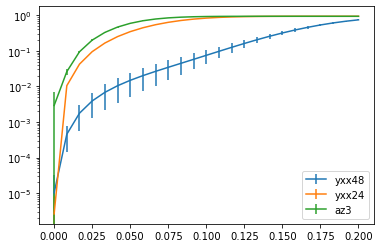

In [161]:
plt.errorbar(phase_transients, 1-yxx48_f_pt, yerr=yxx48_f_pt_std, label='yxx48')
plt.errorbar(phase_transients, 1-yxx24_f_pt, yerr=yxx24_f_pt_std, label='yxx24')
plt.errorbar(phase_transients, 1-az3_f_pt, yerr=az3_f_pt_std, label='az3')
plt.yscale('log')
plt.legend()

## Check candidates from CSV file

In [300]:
df = pd.read_csv('../../data/2021-02/20210213-191154/candidates_sorted.csv')

In [301]:
df['sequence'] = df['sequence'].apply(lambda x: [int(i) for i in x[1:-1].split(',')])

In [302]:
df['last_pulse'] = df['last_pulse'].apply(lambda x: [float(i) for i in x[1:-1].split(',')])

In [303]:
df['last_pulse'] = df['last_pulse'].apply(lambda x: np.argwhere(x)[0][0])

In [304]:
df['full_sequence'] = df['sequence'] + df['last_pulse'].apply(lambda x: [x])

In [316]:
seqs = []
fidelities = []
for i in range(10):
    candidate = df['full_sequence'][i]
    seqs.append(candidate)
    f = ps.get_mean_fidelity(candidate, Utarget, pulses_ensemble)
    fidelities.append(f)
    print(i, f)

0 0.9784564951709153
1 0.9693756534626261
2 0.9861487041698399
3 0.9814814228618427
4 0.9749209861322079
5 0.9590175324306149
6 0.9811328468966448
7 0.9712645299494337
8 0.9811330446913564
9 0.98191224448765


In [298]:
-np.log10(1-0.9924375396910494)

2.1213368916980175

In [222]:
print(df['full_sequence'][23])

[2, 3, 3, 3, 3, 2, 3, 2, 4, 2, 4, 1, 2, 3, 3, 3, 0, 3, 0, 2, 3, 2, 2, 2, 3, 2, 0, 4, 2, 2, 2, 0, 4, 4, 3, 1, 3, 4, 4, 0, 0, 0, 2, 2, 2, 0, 3, 2]


In [264]:
names = [
    r'\tau_{\pi/2}, \tau',
    r'X, \tau',
    r'-X, \tau',
    r'Y, \tau',
    r'-Y, \tau',
]

In [268]:
sequence_string = [names[i] for i in df['full_sequence'][23]]

print('$', ', '.join(sequence_string[:12]), '$')
print('$', ', '.join(sequence_string[12:24]), '$')
print('$', ', '.join(sequence_string[24:36]), '$')
print('$', ', '.join(sequence_string[36:48]), '$')

$ -X, \tau, Y, \tau, Y, \tau, Y, \tau, Y, \tau, -X, \tau, Y, \tau, -X, \tau, -Y, \tau, -X, \tau, -Y, \tau, X, \tau $
$ -X, \tau, Y, \tau, Y, \tau, Y, \tau, \tau_{\pi/2}, \tau, Y, \tau, \tau_{\pi/2}, \tau, -X, \tau, Y, \tau, -X, \tau, -X, \tau, -X, \tau $
$ Y, \tau, -X, \tau, \tau_{\pi/2}, \tau, -Y, \tau, -X, \tau, -X, \tau, -X, \tau, \tau_{\pi/2}, \tau, -Y, \tau, -Y, \tau, Y, \tau, X, \tau $
$ Y, \tau, -Y, \tau, -Y, \tau, \tau_{\pi/2}, \tau, \tau_{\pi/2}, \tau, \tau_{\pi/2}, \tau, -X, \tau, -X, \tau, -X, \tau, \tau_{\pi/2}, \tau, Y, \tau, -X, \tau $


Pulse sequence 23:

$ -X, \tau, Y, \tau, Y, \tau, Y, \tau, Y, \tau, -X, \tau, Y, \tau, -X, \tau, -Y, \tau, -X, \tau, -Y, \tau, X, \tau $
$ -X, \tau, Y, \tau, Y, \tau, Y, \tau, \tau_{\pi/2}, \tau, Y, \tau, \tau_{\pi/2}, \tau, -X, \tau, Y, \tau, -X, \tau, -X, \tau, -X, \tau $
$ Y, \tau, -X, \tau, \tau_{\pi/2}, \tau, -Y, \tau, -X, \tau, -X, \tau, -X, \tau, \tau_{\pi/2}, \tau, -Y, \tau, -Y, \tau, Y, \tau, X, \tau $
$ Y, \tau, -Y, \tau, -Y, \tau, \tau_{\pi/2}, \tau, \tau_{\pi/2}, \tau, \tau_{\pi/2}, \tau, -X, \tau, -X, \tau, -X, \tau, \tau_{\pi/2}, \tau, Y, \tau, -X, \tau $

In [223]:
fidelities = np.array(
    [ps.get_fidelity(df['full_sequence'][23], Utarget, pulses)
     for pulses in pulses_ensemble]
)

In [224]:
np.mean(fidelities)

0.9901248881032397

In [225]:
np.std(fidelities)

0.013279629621136551

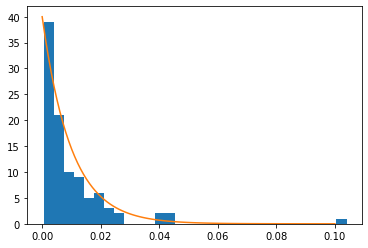

In [231]:
plt.hist(1 - fidelities, bins=30)
# fit exponential curve
X = np.linspace(0, .1, 100)
Y = np.exp(-1 / np.mean(1 - fidelities) * X)
plt.plot(X, Y * 40)